In [1]:
import numpy as np

data = np.load("data.npy")



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm.notebook import trange


def compute_energy(F_i, F_total):

    # if F_total == 0 or F_i == 0:
    #     return 0.0  
    
    # E_nu_i = abs(70 - 60 * torch.sqrt(F_i / F_total))
    E_nu_i = 70 - 60 * torch.sqrt(F_i / F_total)   

    if E_nu_i < 0:
        return 0.0
    elif E_nu_i > 60:
        return 60.0
    else:
        return E_nu_i



X = torch.tensor(data[:, :9], dtype=torch.float32)  
y_main = torch.tensor(data[:, 9:17], dtype=torch.float32)  



F_nue_total = torch.tensor(data[:, 1], dtype=torch.float32)  
F_nue_i = torch.tensor(data[:, 4], dtype=torch.float32)  

F_nueb_total = torch.tensor(data[:, 2], dtype=torch.float32)  
F_nueb_i = torch.tensor(data[:, 6], dtype=torch.float32)  


E_nue_i = torch.tensor([compute_energy(F_nue_i[i], F_nue_total[i]) for i in range(len(F_nue_i))], dtype=torch.float32).unsqueeze(1)

E_nueb_i = torch.tensor([compute_energy(F_nueb_i[i], F_nueb_total[i]) for i in range(len(F_nueb_i))], dtype=torch.float32).unsqueeze(1)


X = torch.cat([X, E_nue_i, E_nueb_i], dim=1)

y_reg = torch.tensor(data[:, 17:20], dtype=torch.float32)  




In [3]:
import numpy as np
import torch
import pysindy as ps
from SALib.sample import morris as morris_sample
from SALib.analyze import morris as morris_analyze
from pysindy.optimizers import SR3

Y = y_main
X_np = X.cpu().detach().numpy()
Y_np = Y.cpu().detach().numpy()
input_features = [f"x_{i}" for i in range(X_np.shape[1])]


problem = {
    'num_vars': X_np.shape[1],
    'names': input_features,
    'bounds': [[-1, 1]] * X_np.shape[1]
}
param_values = morris_sample.sample(problem, N=4000, num_levels=6, optimal_trajectories=10)


threshold = 0.01
model_filtered_list = []  

for i in range(Y_np.shape[1]):
    print(f"\n====== y[{i}] ======")


    library = ps.PolynomialLibrary(degree=1) + ps.FourierLibrary(n_frequencies=1)
    model = ps.SINDy(feature_library=library, optimizer=ps.STLSQ(threshold=0.01))
    model.fit(X_np, x_dot=Y_np[:, i])
    Y_pred = model.predict(param_values)


    Si = morris_analyze.analyze(problem, param_values, Y_pred.flatten(), conf_level=0.95, print_to_console=False)
    mu_star = np.array(Si['mu_star'])
    important_indices = np.where(mu_star > threshold)[0]

    if len(important_indices) == 0:
        print(f"[Skip] y[{i}] no important vars")
        model_filtered_list.append(None)
        continue

    X_filtered = X_np[:, important_indices]
    filtered_names = [input_features[j] for j in important_indices]

    # rebulit
    model_filtered = ps.SINDy(
        feature_library=library,
        optimizer=ps.STLSQ(threshold=0.01),
        # optimizer=ps.SR3(threshold=0.1, nu=1, tol=1e-6),
        feature_names=filtered_names
    )
    model_filtered.fit(X_filtered, x_dot=Y_np[:, i])
    print(f"[Complete] y[{i}] use {len(filtered_names)} vars rebulit")
    model_filtered_list.append(model_filtered)


(CVXPY) Jul 11 02:49:52 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.12.4544). Expected < 9.12.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jul 11 02:49:52 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.12.4544). Expected < 9.12.0. Please open a feature request on cvxpy to enable support for this version.')


load c:\Users\Lenovo\miniconda3\envs\rl\lib\site-packages\ortools\.libs\zlib1.dll...
load c:\Users\Lenovo\miniconda3\envs\rl\lib\site-packages\ortools\.libs\abseil_dll.dll...
load c:\Users\Lenovo\miniconda3\envs\rl\lib\site-packages\ortools\.libs\utf8_validity.dll...
load c:\Users\Lenovo\miniconda3\envs\rl\lib\site-packages\ortools\.libs\re2.dll...
load c:\Users\Lenovo\miniconda3\envs\rl\lib\site-packages\ortools\.libs\libprotobuf.dll...
load c:\Users\Lenovo\miniconda3\envs\rl\lib\site-packages\ortools\.libs\highs.dll...
load c:\Users\Lenovo\miniconda3\envs\rl\lib\site-packages\ortools\.libs\ortools.dll...

====== y[0] ======
[Complete] y[0] use 6 vars rebulit

====== y[1] ======
[Complete] y[1] use 6 vars rebulit

====== y[2] ======
[Complete] y[2] use 5 vars rebulit

====== y[3] ======
[Complete] y[3] use 4 vars rebulit

====== y[4] ======
[Complete] y[4] use 5 vars rebulit

====== y[5] ======
[Complete] y[5] use 7 vars rebulit

====== y[6] ======
[Complete] y[6] use 5 vars rebulit



In [4]:
import re

def fix_expr_str(expr):
    expr = expr.replace('^', '**')
    expr = re.sub(r'(?<=\w)\s+(?=\w)', '*', expr)
    expr = re.sub(
        r'(\b(?:sin|cos|tan|exp|log))\(([^)]*?)\)',
        lambda m: m.group(1) + '(' + re.sub(r'(?<=\d)\s+(?=x_\d)', '*', m.group(2)) + ')',
        expr
    )
    return expr

expressions_all = []

for i, model in enumerate(model_filtered_list):
    if model is None:
        expressions_all.append(f"y[{i}] = 0.0")
        continue

    coefs = model.coefficients()[0]
    feature_names = model.get_feature_names()
    terms = []
    for coef, fname in zip(coefs, feature_names):
        if abs(coef) > 1e-12:
            if fname == '1':
                terms.append(f"{coef:.16g}")
            else:
                terms.append(f"{coef:.16g}*({fname})")
    expr = " + ".join(terms) if terms else "0.0"
    expr_fixed = fix_expr_str(expr)
    expressions_all.append(expr_fixed)  



print("\nanalytic_model = ([")
for expr in expressions_all:
    print(f'  "{expr}",')
print(f"], {input_features})")



analytic_model = ([
  "0.01241420581936836 + -0.002117913216352463*(x_0) + -0.02494936436414719*(x_1) + 0.06446751952171326*(x_2) + 0.1757289320230484*(x_7) + -0.01204259134829044*(x_8) + 0.01775183342397213*(cos(1*x_0)) + -0.01836088299751282*(sin(1*x_1)) + 0.03000439517199993*(cos(1*x_1)) + 0.04919640347361565*(sin(1*x_2)) + -0.02737060934305191*(cos(1*x_2)) + 0.01438299380242825*(cos(1*x_4)) + 0.1637067198753357*(sin(1*x_7)) + -0.04283741116523743*(cos(1*x_7)) + -0.0100325345993042*(sin(1*x_8)) + 0.01875980943441391*(cos(1*x_8))",
  "-0.01183282118290663*(x_0) + -0.02140488103032112*(x_1) + 0.04156730324029922*(x_2) + 0.03697246313095093*(x_4) + 0.0649663582444191*(x_7) + 0.0400463193655014*(x_8) + 0.03172977641224861*(sin(1*x_0)) + 0.01450894586741924*(cos(1*x_0)) + -0.01657970622181892*(sin(1*x_1)) + 0.01089741289615631*(cos(1*x_1)) + 0.03049828298389912*(sin(1*x_2)) + -0.03025093860924244*(cos(1*x_2)) + -0.01659289374947548*(cos(1*x_4)) + 0.060410525649786*(sin(1*x_7)) + -0.0231

In [5]:
import numpy as np
import re
import pysindy as ps


input_features = [f"x_{i}" for i in range(X_np.shape[1])]


feature_names = model.feature_library.get_feature_names(input_features)


coefs = model.coefficients()


expressions = []
for i, coef_row in enumerate(coefs):
    terms = []
    for coef, fname in zip(coef_row, feature_names):
        if abs(coef) > 1e-12:  
            if fname == '1':
                terms.append(f"{coef:.16g}")
            else:
                terms.append(f"{coef:.16g}*({fname})")
    expr = " + ".join(terms) if terms else "0.0"
    expressions.append(expr)


def fix_expr_str(expr):

    expr = expr.replace('^', '**')


    expr = re.sub(r'(?<=\w)\s+(?=\w)', '*', expr)


    expr = re.sub(
        r'(\b(?:sin|cos|tan|exp|log))\(([^)]*?)\)',
        lambda m: m.group(1) + '(' + re.sub(r'(?<=\d)\s+(?=x_\d)', '*', m.group(2)) + ')',
        expr
    )
    return expr


analytic_model = ([fix_expr_str(e) for e in expressions_all], input_features)


print("analytic_model = ([")
for expr in analytic_model[0]:
    print(f'  "{expr}",')
print(f"], {analytic_model[1]})")


analytic_model = ([
  "0.01241420581936836 + -0.002117913216352463*(x_0) + -0.02494936436414719*(x_1) + 0.06446751952171326*(x_2) + 0.1757289320230484*(x_7) + -0.01204259134829044*(x_8) + 0.01775183342397213*(cos(1*x_0)) + -0.01836088299751282*(sin(1*x_1)) + 0.03000439517199993*(cos(1*x_1)) + 0.04919640347361565*(sin(1*x_2)) + -0.02737060934305191*(cos(1*x_2)) + 0.01438299380242825*(cos(1*x_4)) + 0.1637067198753357*(sin(1*x_7)) + -0.04283741116523743*(cos(1*x_7)) + -0.0100325345993042*(sin(1*x_8)) + 0.01875980943441391*(cos(1*x_8))",
  "-0.01183282118290663*(x_0) + -0.02140488103032112*(x_1) + 0.04156730324029922*(x_2) + 0.03697246313095093*(x_4) + 0.0649663582444191*(x_7) + 0.0400463193655014*(x_8) + 0.03172977641224861*(sin(1*x_0)) + 0.01450894586741924*(cos(1*x_0)) + -0.01657970622181892*(sin(1*x_1)) + 0.01089741289615631*(cos(1*x_1)) + 0.03049828298389912*(sin(1*x_2)) + -0.03025093860924244*(cos(1*x_2)) + -0.01659289374947548*(cos(1*x_4)) + 0.060410525649786*(sin(1*x_7)) + -0.02311

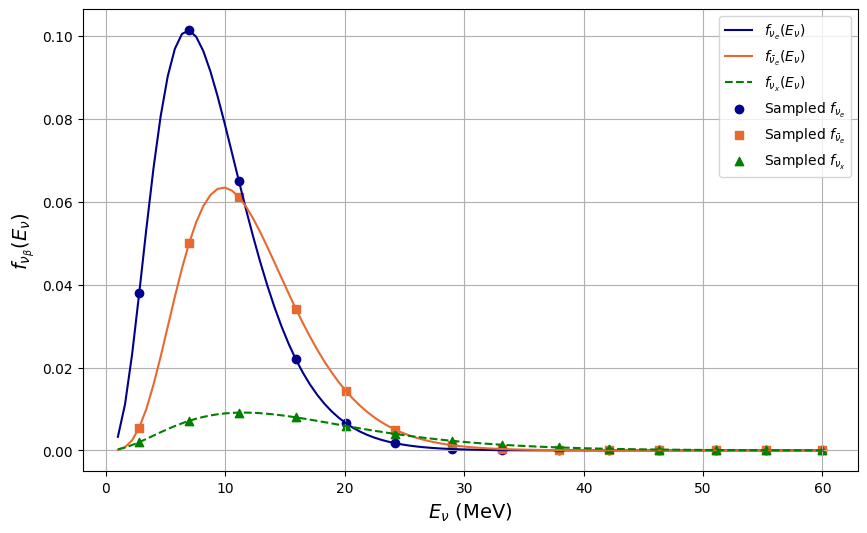

[[0.14504277101416002,
  0.5,
  0.7,
  0.0380195527056343,
  0.6274262830323437,
  0.005514461277144104,
  0.8783967962452812,
  0.0020042776874742594,
  1.0038820528517498,
  2.7878787878787876,
  2.7878787878787876],
 [0.493284214576731,
  0.5,
  0.7,
  0.10137114883594793,
  0.5519572974413042,
  0.050004787534281475,
  0.7727402164178259,
  0.007135435156490484,
  0.8831316759060868,
  6.959595959595959,
  6.959595959595959],
 [0.9404728231574233,
  0.5,
  0.7,
  0.06502926995008267,
  0.4813225407838203,
  0.06115826109782044,
  0.6738515570973485,
  0.009123955769767201,
  0.7701160652541126,
  11.13131313131313,
  11.13131313131313],
 [1.5555039612351378,
  0.5,
  0.7,
  0.02199248174729033,
  0.40651656860411073,
  0.034209392475301574,
  0.569123196045755,
  0.007982910054765624,
  0.6504265097665772,
  15.898989898989898,
  15.898989898989898],
 [2.180319555963289,
  0.5,
  0.7,
  0.00661617833740039,
  0.34624087394710285,
  0.01442538301477475,
  0.484737223525944,
  0.0059

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import pandas as pd


L_nu_e = 1
L_nu_bar_e = 1
L_nu_x = 0.33
E_nu_e_avg = 9
E_nu_bar_e_avg = 12
E_nu_x_avg = 16.5
n_nu_e = 3.2
n_nu_bar_e = 4.5
n_nu_x = 2.3

T_nu_e = E_nu_e_avg / (1 + n_nu_e)
T_nu_bar_e = E_nu_bar_e_avg / (1 + n_nu_bar_e)
T_nu_x = E_nu_x_avg / (1 + n_nu_x)


def f_nu(E_nu, T_nu, n_nu):
    return (1 / (T_nu * gamma(1 + n_nu))) * (E_nu / T_nu)**n_nu * np.exp(-E_nu / T_nu)


E_nu = np.linspace(1, 60, 100)


f_nu_e = f_nu(E_nu, T_nu_e, n_nu_e)
f_nu_bar_e = f_nu(E_nu, T_nu_bar_e, n_nu_bar_e) * ((E_nu_e_avg / E_nu_bar_e_avg) / (L_nu_e / L_nu_bar_e)) 
f_nu_x = f_nu(E_nu, T_nu_x, n_nu_x) * ((E_nu_e_avg / E_nu_x_avg) / (L_nu_e / L_nu_x))




num_points = 14
indices = np.linspace(3, len(E_nu)-1, num_points, dtype=int)
E_nu_sampled = E_nu[indices]
n_nue_sampled = f_nu_e[indices]
n_nueb_sampled = f_nu_bar_e[indices]
n_nux_sampled = f_nu_x[indices]



threshold_nue = 8e-9
threshold_nueb = 8e-9
threshold_nux = 8e-9

n_nue_sampled = np.maximum(n_nue_sampled, threshold_nue)
n_nueb_sampled = np.maximum(n_nueb_sampled, threshold_nueb)
n_nux_sampled = np.maximum(n_nux_sampled, threshold_nux)


F_nue_tot = 0.5
F_nueb_tot = 0.7
F_nux_tot = 0.8

F_nue_sampled = F_nue_tot * (70 - E_nu_sampled) ** 2 / 60 ** 2
F_nueb_sampled = F_nueb_tot * (70 - E_nu_sampled) ** 2 / 60 ** 2
F_nux_sampled = F_nux_tot * (70 - E_nu_sampled) ** 2 / 60 ** 2


alpha_sampled = n_nueb_sampled/ n_nue_sampled

plt.figure(figsize=(10, 6))
plt.plot(E_nu, f_nu_e, label=r'$f_{\nu_e}(E_\nu)$', color=(0, 0, 139/255), linestyle='-')
plt.plot(E_nu, f_nu_bar_e, label=r'$f_{\bar{\nu}_e}(E_\nu)$', color=(232/255, 105/255, 48/255), linestyle='-')
plt.plot(E_nu, f_nu_x, label=r'$f_{\nu_x}(E_\nu)$', color='green', linestyle='--')


plt.scatter(E_nu_sampled, n_nue_sampled, color=(0, 0, 139/255), marker='o', label=r'Sampled $f_{\nu_e}$')
plt.scatter(E_nu_sampled, n_nueb_sampled, color=(232/255, 105/255, 48/255), marker='s', label=r'Sampled $f_{\bar{\nu}_e}$')
plt.scatter(E_nu_sampled, n_nux_sampled, color='green', marker='^', label=r'Sampled $f_{\nu_x}$')


#plt.title(r"Neutrino Spectra with Sampled Points", fontsize=16)
plt.xlabel(r"$E_\nu$ (MeV)", fontsize=14)
plt.ylabel(r"$f_{\nu_\beta}(E_\nu)$", fontsize=14)
plt.legend(loc='best')
plt.grid(True)
plt.show()


data_test = {
    "alpha": alpha_sampled,
    "F_nue_tot": np.full(num_points, F_nue_tot),
    "F_nueb_tot": np.full(num_points, F_nueb_tot),
    "n_nue": n_nue_sampled,
    "F_nue": F_nue_sampled,
    "n_nueb": n_nueb_sampled,
    "F_nueb": F_nueb_sampled,
    "n_nux": n_nux_sampled,
    "F_nux": F_nux_sampled,
    "E_nu": E_nu_sampled,
    "E_nub": E_nu_sampled,
}


df = pd.DataFrame(data_test)


matrix_data = df.values.tolist()


matrix_data


In [7]:
import torch
import numpy as np
import math

def check_parentheses(expr: str):
    bal = 0
    for i, ch in enumerate(expr):
        if ch == '(':
            bal += 1
        elif ch == ')':
            bal -= 1
            if bal < 0:
                return False, i
    return bal == 0, None

def parse_analytic_model(model_structure):
    expr_list, var_names = model_structure
    if not isinstance(expr_list, (list, tuple)):
        raise TypeError("expr_list must be list or tuple")
    if not isinstance(var_names, (list, tuple)):
        raise TypeError("var_names must be list or tuple")
    return expr_list, var_names

def eval_analytic_model(test_X, model_structure):
    expr_list, var_names = parse_analytic_model(model_structure)

    # check format
    compiled = []
    for idx, expr in enumerate(expr_list):
        ok, pos = check_parentheses(expr)
        if not ok:
            raise ValueError(f"#{idx} error, pos in {pos}：\n{expr}")
        try:
            compiled.append(compile(expr, '<expr>', 'eval'))
        except SyntaxError as e:
            raise SyntaxError(f" #{idx} syntax error：\n{expr}\n{e}")


    arr = test_X.cpu().numpy() if hasattr(test_X, 'cpu') else np.asarray(test_X)


    math_funcs = {
        "sin":   math.sin,
        "cos":   math.cos,
        "tan":   math.tan,
        "exp":   math.exp,
        "log":   math.log,
        "tanh":  math.tanh,
        "Abs":   abs,           
        "abs":   abs,           
        "sqrt":  math.sqrt,     
        "pow":   pow,           
        "floor": math.floor,    
        "ceil":  math.ceil,     #
    }
    math_funcs["__builtins__"] = {}

    outputs = []
    for row in arr:

        ctx = math_funcs.copy()
        ctx.update({var_names[i]: float(row[i]) for i in range(len(var_names))})
        vals = [eval(co, ctx) for co in compiled]
        outputs.append(vals)

    out = np.array(outputs, dtype=np.float32)
    return torch.tensor(out, device=test_X.device) if hasattr(test_X, 'device') else out


In [8]:
test_X = torch.tensor([row[0:11] for row in matrix_data], dtype=torch.float32)

In [9]:

analytic_outputs_analytic = eval_analytic_model(test_X, analytic_model)

predictions_nue_analytic   = analytic_outputs_analytic[:, 0:2]
predictions_nueb_analytic  = analytic_outputs_analytic[:, 2:4]
predictions_nux_analytic   = analytic_outputs_analytic[:, 4:6]
predictions_nuxb_analytic  = analytic_outputs_analytic[:, 6:8]
print("Analytic I0/I1 ν_e:", predictions_nue_analytic.cpu().numpy())

Analytic I0/I1 ν_e: [[ 0.04962151  0.07802967]
 [ 0.05329787  0.07057464]
 [ 0.05204315  0.05980042]
 [ 0.04443769  0.03728177]
 [ 0.03528216  0.00505074]
 [ 0.02902051 -0.03671077]
 [ 0.03244704 -0.08211454]
 [ 0.04586059 -0.10171925]
 [ 0.06164023 -0.09247335]
 [ 0.05988074 -0.07914197]
 [ 0.04047633 -0.0989813 ]
 [ 0.02403463 -0.16625805]
 [ 0.03774883 -0.20191447]
 [ 0.04046184 -0.07903422]]


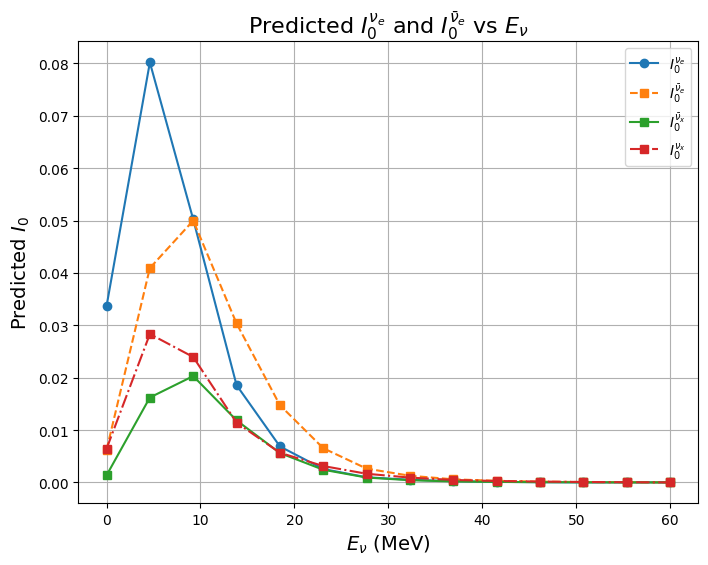

In [10]:


I0_nue0_analytic = predictions_nue_analytic[:, 0].cpu().numpy() 
I0_nueb0_analytic = predictions_nueb_analytic[:, 0].cpu().numpy() 
I0_nux0_analytic = predictions_nux_analytic[:, 0].cpu().numpy() 
I0_nuxb0_analytic = predictions_nuxb_analytic[:, 0].cpu().numpy() 

E_nu_values = np.linspace(0, 60, len(I0_nue0_analytic))



norm_par = (n_nue_sampled + n_nux_sampled + n_nueb_sampled + n_nux_sampled) / (I0_nue0_analytic + I0_nux0_analytic + I0_nueb0_analytic + I0_nuxb0_analytic)

I0_nue1_analytic =  I0_nue0_analytic * (n_nue_sampled + n_nux_sampled) / (I0_nue0_analytic + I0_nux0_analytic)
I0_nueb1_analytic = I0_nueb0_analytic * (n_nueb_sampled + n_nux_sampled) / (I0_nueb0_analytic + I0_nuxb0_analytic)
I0_nux1_analytic = I0_nux0_analytic * (n_nue_sampled + n_nux_sampled) / (I0_nue0_analytic + I0_nux0_analytic)
I0_nuxb1_analytic = I0_nuxb0_analytic * (n_nueb_sampled + n_nux_sampled) / (I0_nueb0_analytic + I0_nuxb0_analytic)




plt.figure(figsize=(8,6))
plt.plot(E_nu_values, I0_nue1_analytic, label=r"$I_0^{\nu_e}$", marker='o', linestyle='-')
plt.plot(E_nu_values, I0_nueb1_analytic, label=r"$I_0^{\bar{\nu}_e}$", marker='s', linestyle='--')
plt.plot(E_nu_values, I0_nuxb1_analytic, label=r"$I_0^{\bar{\nu}_x}$", marker='s', linestyle='-')
plt.plot(E_nu_values, I0_nux1_analytic, label=r"$I_0^{\nu_x}$", marker='s', linestyle='-.')

plt.xlabel(r"$E_\nu$ (MeV)", fontsize=14)
plt.ylabel(r"Predicted $I_0$", fontsize=14)
# plt.yscale('log')
plt.title(r"Predicted $I_0^{\nu_e}$ and $I_0^{\bar{\nu}_e}$ vs $E_\nu$", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

In [11]:
import numpy as np

# 构造要保存的数据
data_to_save = {
    'E_nu': np.array(E_nu_values),
    'I0_nue': I0_nue1_analytic,
    'I0_nueb': I0_nueb1_analytic,
    'I0_nux': I0_nux1_analytic,
    'I0_nuxb': I0_nuxb1_analytic
}

# 保存为 .npy 文件
np.save('I0_vs_Enu_analytic_SA.npy', data_to_save)


In [12]:
loaded_test_data = np.load('I0_vs_Enu_analytic_SA.npy', allow_pickle=True).item()

E_nu_values = loaded_test_data['E_nu']
I0_nue = loaded_test_data['I0_nue']
I0_nueb = loaded_test_data['I0_nueb']
I0_nux = loaded_test_data['I0_nux']
I0_nuxb = loaded_test_data['I0_nuxb']

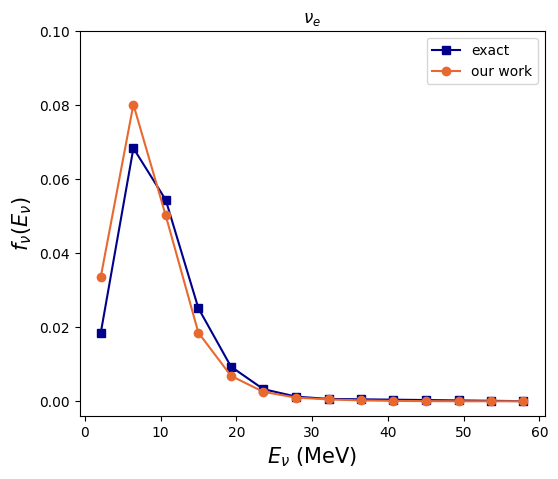

In [13]:
import numpy as np
import matplotlib.pyplot as plt


data_exact_nue = np.loadtxt('spectrum_nue_exact.txt', delimiter=',')
data_pinn_nue = I0_nue 

energy = data_exact_nue[:, 0]  
f_values_exact_nue = data_exact_nue[:, 1]  
f_values_pinn_nue = I0_nue  

plt.figure(figsize=(6, 5))
plt.plot(energy, f_values_exact_nue, marker='s',color=(0, 0, 139/255), linestyle='-', label='exact')  
plt.plot(energy, f_values_pinn_nue, marker='o',color=(232/255, 105/255, 48/255), linestyle='-', label='our work')  
plt.xlabel(r'$E_\nu$ (MeV)', fontsize=15)
plt.ylabel(r'$f_\nu(E_\nu)$', fontsize=15)
plt.title(r'${\nu}_e$')
plt.ylim(top=0.1)
# plt.grid(True)
plt.legend()
plt.savefig("analytic_nue.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()


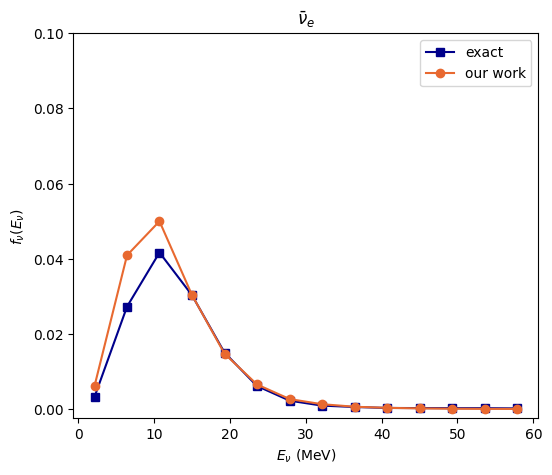

In [14]:
import numpy as np
import matplotlib.pyplot as plt


data_exact_nueb = np.loadtxt('spectrum_nueb_exact.txt', delimiter=',')


energy = data_exact_nueb[:, 0] 
f_values_exact_nueb = data_exact_nueb[:, 1]  
f_values_pinn_nueb = I0_nueb    

plt.figure(figsize=(6, 5))
plt.plot(energy, f_values_exact_nueb, marker='s',color=(0, 0, 139/255), linestyle='-', label='exact') 
plt.plot(energy, f_values_pinn_nueb, marker='o',color=(232/255, 105/255, 48/255), linestyle='-', label='our work')  
plt.xlabel(r'$E_\nu$ (MeV)', fontsize=10)
plt.ylabel(r'$f_\nu(E_\nu)$', fontsize=10)
plt.title(r'$\bar{\nu}_e$')
plt.ylim(top=0.1)
# plt.grid(True)
plt.legend()
plt.savefig("analytic_nueb.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()


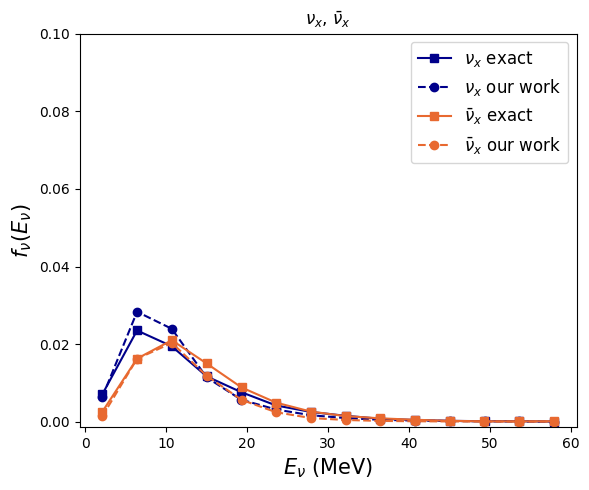

In [15]:
import numpy as np
import matplotlib.pyplot as plt


data_exact_nuxb = np.loadtxt('spectrum_nuxb_exact.txt', delimiter=',')
energy_nuxb = data_exact_nuxb[:, 0]
f_values_exact_nuxb = data_exact_nuxb[:, 1]
f_values_pinn_nuxb = I0_nuxb


data_exact_nux = np.loadtxt('spectrum_nux_exact.txt', delimiter=',')
energy_nux = data_exact_nux[:, 0]
f_values_exact_nux = data_exact_nux[:, 1]
f_values_pinn_nux = I0_nux


plt.figure(figsize=(6, 5))


plt.plot(energy_nux, f_values_exact_nux, marker='s', color=(0, 0, 139/255), 
         linestyle='-', label=r'$\nu_x$ exact')
plt.plot(energy_nux, f_values_pinn_nux, marker='o', color=(0, 0, 139/255), 
         linestyle='--', label=r'$\nu_x$ our work')



plt.plot(energy_nuxb, f_values_exact_nuxb, marker='s', color=(232/255, 105/255, 48/255), 
         linestyle='-', label=r'$\bar{\nu}_x$ exact')
plt.plot(energy_nuxb, f_values_pinn_nuxb, marker='o', color=(232/255, 105/255, 48/255), 
         linestyle='--', label=r'$\bar{\nu}_x$ our work')


plt.ylim(top=0.1)

plt.title(r'$\nu_x$, $\bar{\nu}_x$')
plt.xlabel(r'$E_\nu$ (MeV)', fontsize=15)
plt.ylabel(r'$f_\nu(E_\nu)$', fontsize=15)
# plt.grid(True)
plt.legend(fontsize=12)


plt.tight_layout()
plt.savefig("analytic_nux&nuxb.pdf", format='pdf', bbox_inches='tight',dpi=300)
plt.show()

In [16]:
import numpy as np

import sys


def compute_delta_nu(f_exact, f_pinn):
    n_total = np.sum(f_exact)
    delta = np.sum((f_exact / n_total) * np.abs((f_pinn - f_exact) / f_exact))
    return delta


# nue
delta_nue = compute_delta_nu(f_values_exact_nue, f_values_pinn_nue)


# nuebar
delta_nueb = compute_delta_nu(f_values_exact_nueb, f_values_pinn_nueb)


# nux
delta_nux = compute_delta_nu(f_values_exact_nux, f_values_pinn_nux)


# nuxbar
delta_nuxb = compute_delta_nu(f_values_exact_nuxb, f_values_pinn_nuxb)


print(f"δ_nue = {delta_nue:.5e}")
print(f"δ_nueb = {delta_nueb:.5e}")
print(f"δ_nux = {delta_nux:.5e}")
print(f"δ_nuxb = {delta_nuxb:.5e}")
print(f"total = {delta_nue + delta_nueb + delta_nuxb + delta_nux}")


δ_nue = 2.33329e-01
δ_nueb = 2.10997e-01
δ_nux = 1.92623e-01
δ_nuxb = 1.99573e-01
total = 0.8365218287239535
